In [2]:
import cometspy as c 
import cobra
import cobra.io
from cobra.io import read_sbml_model
from matplotlib import pyplot as plt
import gurobipy

In [3]:
ecoli_wt = read_sbml_model("iML1515.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12


In [4]:
#Creation of the cobra models
ecoli_A_wt=ecoli_wt.copy()
ecoli_A_wt.reactions.ICL.knock_out()
ecoli_A_wt.reactions.MALS.knock_out()
ecoli_A_wt.reactions.get_by_id("EX_glc__D_e").bounds=(-10,0)
ecoli_A_wt.reactions.get_by_id("EX_o2_e").bounds=(-18,0)


ecoli_B=ecoli_wt.copy()
ecoli_B.reactions.get_by_id("ATPM").bounds=(7.2, 1000.0)
ecoli_B.reactions.get_by_id("EX_glc__D_e").bounds=(-10,0)
ecoli_B.reactions.get_by_id("EX_o2_e").bounds=(-18,0)
ecoli_B.reactions.get_by_id("ICL").bounds=(5,1000)
ecoli_B.reactions.get_by_id("MALS").bounds=(5,1000)
ecoli_B.reactions.get_by_id("EX_ac_e").bounds=(-1000,0)

ecoli_A_wt.id = "wt_A"
ecoli_B.id = "acetate_adapted_B"

Read LP format model from file /tmp/tmpr5tlsx8z.lp
Reading time = 0.10 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file /tmp/tmphb046c0o.lp
Reading time = 0.06 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [5]:
#Creation of comets model with initial populations (sum=0.1)
ecoli_A_wt_comets = c.model(ecoli_A_wt)
ecoli_A_wt_comets.initial_pop = [0,0,0.073] # x, y, gDW

ecoli_B_comets=c.model(ecoli_B)
ecoli_B_comets.initial_pop = [0,0,0.027]



In [6]:
#Set the exchange metabolite names from LB
import pandas as pd
df = pd.read_csv('media_db.tsv', sep='\t')
filtered_rows = df[df.iloc[:, 0] == 'M9']
metabolites_M9 = filtered_rows.iloc[:, 2].tolist()
exchange_metabolites_M9 = []
for i in metabolites_M9:
    new_element = str(i) + "_e"
    exchange_metabolites_M9.append(new_element)
print(exchange_metabolites_M9)


['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'glc__D_e', 'h2o_e', 'h_e', 'k_e', 'mg2_e', 'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'o2_e', 'pi_e', 'so4_e', 'zn2_e']


In [7]:
#Build the layout with the models of interest and set the media with the list of LB metabolites
ly_M9 = c.layout([ecoli_B_comets,ecoli_A_wt_comets])
for metabolite in exchange_metabolites_M9:
    ly_M9.set_specific_metabolite(metabolite,1000,static=False)
ly_M9.set_specific_metabolite("glc__D_e", 10)

In [8]:
#Set parameters of the simulation
p = c.params()
p.set_param("timeStep", 0.1)
p.set_param("maxCycles", 40)
p.set_param("useLogNameTimeStamp", False)
p.set_param("spaceWidth",0.05)
p.set_param("allowCellOverlap",True)
p.set_param("cellSize",4.3e-13)
p.set_param("deathRate", 0.00)
p.set_param("dilFactor",1e-2)
p.set_param("dilTime", 12)
p.set_param("numRunThreads", 1)
p.set_param("maxSpaceBiomass",100)
p.set_param("defaultVmax",20)
p.set_param("defaultKm",0.01)
p.set_param("defaultHill",1)
p.set_param("showCycleTime", True)
p.set_param("geneFractionalCost", 0)
p.set_param("writeTotalBiomassLog", True)
p.set_param("writeBiomassLog", True)
p.set_param("writeMediaLog",True)
p.set_param("useLogNameTimeStamp", False)
p.set_param("flowDiffRate", 1e-7)
p.set_param("growthDiffRate",1e-7)
p.set_param("FluxLogRate", 1)
p.set_param("MediaLogRate", 1)
p.set_param("numExRxnSubsteps",12)
p.set_param("geneFractionalCost",0)
p.set_param("exchangestyle", "Standard FBA")
p.set_param("biomassMotionStyle","Diffusion 2D(Crank-Nicolson)")
p.set_param("mutRate",1e-9)
p.set_param("addRate", 1e-9)
p.set_param("minSpaceBiomass", 1e-10)


Running COMETS simulation ...


/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-

Done!


Text(0, 0.5, 'biomass (gDW)')

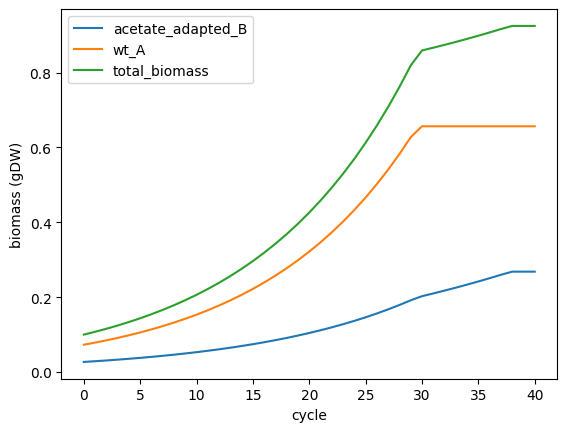

In [9]:
#Run the query simulation
sim_M9= c.comets(ly_M9, p)
sim_M9.run(delete_files=True)
sim_M9.total_biomass['total_biomass'] = sim_M9.total_biomass.iloc[:, 1:].sum(axis=1)
sim_M9.total_biomass.plot(x = "cycle",logy = False)
plt.ylabel("biomass (gDW)")

Text(0, 0.5, 'concentration (mmol/l)')

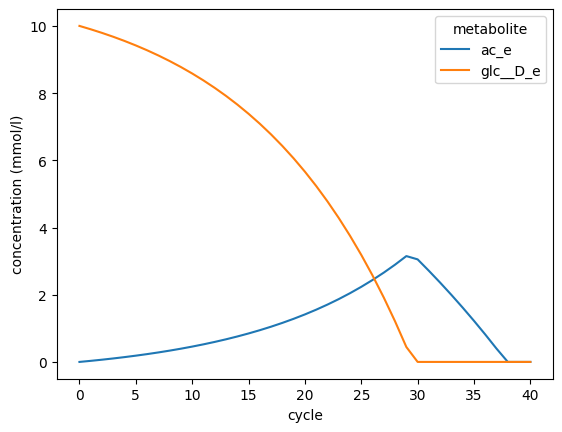

In [10]:
media_ac_glc=sim_M9.get_metabolite_time_series(upper_threshold=100.)
media_ac_glc[["ac_e","glc__D_e","cycle"]].plot(x="cycle")
plt.ylabel("concentration (mmol/l)")

In [12]:
ecoli_wild_type=ecoli_wt.copy()
ecoli_wild_type.reactions.get_by_id("EX_glc__D_e").bounds=(-10,0)
ecoli_wild_type.reactions.get_by_id("EX_o2_e").bounds=(-18,0)
ecoli_wild_type.id = "wild_type"
ecoli_wild_type_comets = c.model(ecoli_wild_type)
ecoli_wild_type_comets.initial_pop = [0,0,0.1]

Read LP format model from file /tmp/tmpmywkf_9w.lp
Reading time = 0.13 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [13]:
ecoli_wt_01_comets=c.model(ecoli_A_wt)
ecoli_wt_01_comets.initial_pop = [0,0,0.1]
ly_wt = c.layout([ecoli_wt_01_comets])
for metabolite in exchange_metabolites_M9:
    ly_wt.set_specific_metabolite(metabolite,1000,static=False)
ly_wt.set_specific_metabolite("glc__D_e", 10)


Running COMETS simulation ...


/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)


Done!


Text(0, 0.5, 'biomass (gDW)')

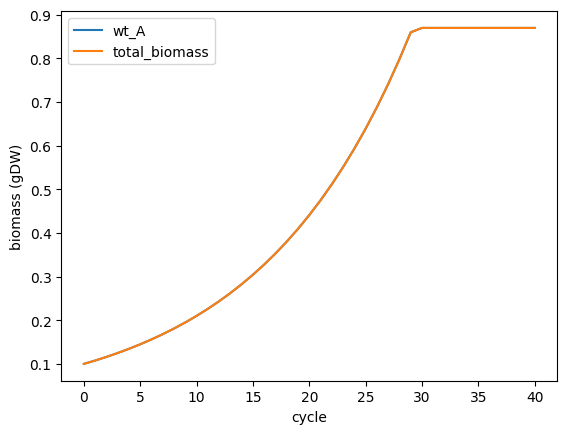

In [14]:
sim_wt= c.comets(ly_wt, p)
sim_wt.run(delete_files=True)
sim_wt.total_biomass['total_biomass'] = sim_wt.total_biomass.iloc[:, 1:].sum(axis=1)
sim_wt.total_biomass.plot(x = "cycle",logy = False)
plt.ylabel("biomass (gDW)")

In [16]:
#merge plot 
merged_biomass=pd.concat([sim_M9.total_biomass, sim_wt.total_biomass["wild_type"]], axis=1)
merged_biomass.plot(x="cycle")
plt.ylabel("biomass (gDW)")

KeyError: 'wild_type'

In [ ]:
media_ac_glc_wt=sim_wt.get_metabolite_time_series(upper_threshold=100.)
media_ac_glc_wt[["ac_e","glc__D_e","cycle"]].plot(x="cycle")
plt.ylabel("concentration (mmol/l)")